# Inpainting with the deep decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL
import imageio as io
from skimage.transform import resize

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Helping functions

In [2]:
def get_ldrs(x,T,tau,j,p):
    
    LDRs=[]
    # defining delta t's
    dts=list(np.flip( [ 1/(tau**i) for i in np.arange(1,T//2+1) ] ))
    dts=dts+[1]
    dts=dts+[tau**i for i in np.arange(1,T//2+1)]
    for i in range(T+1):
        LDRs.append(x*dts[i])
    # Normalizing LDRs
    c=0.5/np.mean(LDRs[T//2])
    for i in range(T+1):
        LDRs[i]=np.power(np.clip(LDRs[i]*c,0,1),p)
        
    
    return LDRs[T//2], c*dts[T//2]

class camera_model:
    
    def __init__(self,dts,p):
        self.dts=dts
        self.p=p
    def __call__(self,x):
        
        x=x*dts
#         x=torch.nn.functional.relu(-x+1)
        x=torch.nn.functional.leaky_relu(-x+1)
        x=-x+1
        x=torch.pow(x,p)
        return x

def psnr(x_hat,x_true,maxv=1.):
    x_true=x_true/x_true.max()
    x_hat=x_hat/x_hat.max()
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse=np.mean(np.square(x_hat-x_true))
    psnr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    return psnr_
    

## Load image

In [3]:
# path = './test_data/'
img_name = "forest_path"

# img_path = path + img_name + ".png"
# img_pil = Image.open(img_path)
# img_np = pil_to_np(img_pil)
img=io.imread("pfstools_hdr_images/hdr_gallery/"+img_name+".hdr",format='HDR-FI')
print("image_Shape:",img.shape)
img=resize(img,(1024,1024))
img_np=np.array(img).transpose((2,1,0))
img_np=img_np/img_np.max()
img_clean_var = np_to_var(img_np).type(dtype)
output_depth = img_np.shape[0]


image_Shape: (1536, 2048, 3)


In [4]:
img_np.max()

1.0

## Define camera parameters

In [5]:
T=4
j=[i for i in range(T+1)]
tau=np.sqrt(3)
p=0.4
img_noisy_np,dts_np=get_ldrs(img_np,T,tau,j,p)
img_noisy_var = np_to_var(img_noisy_np).type(dtype)
dts = torch.tensor(dts_np).type(dtype)
apply_function=camera_model(dts,0.4)

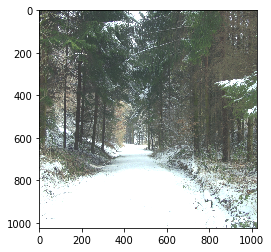

In [6]:
plt.imshow(img_noisy_np.transpose((2,1,0)))

In [7]:
psnr(img_noisy_np,img_np)


4.980361836089239

## Recover image

In [8]:
num_channels = [128]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))

rnd = 500
numit = 20000
rn = 0.005

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        apply_f=apply_function,
                        find_best=True,
                        )

number of parameters:  100224
shape:  [1, 128, 32, 32]
optimize with adam 0.0025


(-0.5, 1023.5, 1023.5, -0.5)

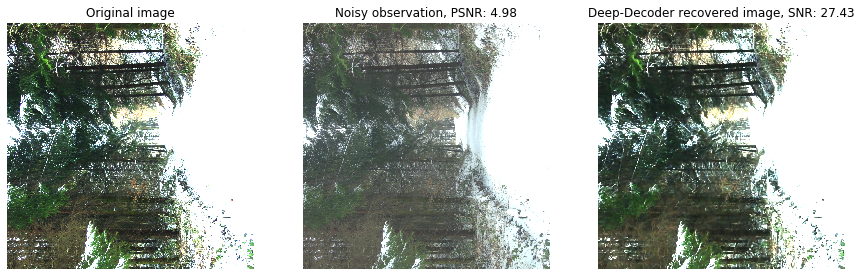

In [11]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))

 
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1,img_np*50) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
myimgshow(ax2,img_noisy_np)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
ax2.axis('off')

out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
ax3 = fig.add_subplot(133)
myimgshow(ax3,out_img_np*50)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_np,out_img_np) ) 
ax3.axis('off')  

In [12]:
io.imwrite("hr/single_"+img_name+".hdr",out_img_np.transpose(2,1,0),format='HDR-FI')